In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## step1：读取数据

In [3]:
file = '/kaggle/input/crypto-ohlcvt/crypto_OHLCVT_10min.csv'
df = pd.read_csv(file, dtype={'Volume': 'float64', 'Trades': 'float64'})
df = df.sort_values(by=['asset','date']).reset_index(drop=True)

## step2：构建特征与数据标签
1. 特征：动量因子（过去1小时，3小时，6小时，12小时，24小时收益率）
2. 数据标签：即预测对象，为未来一个小时的收益率

In [19]:
grouped = df.groupby('asset')

df['return_60m'] = grouped['Close'].pct_change(periods=6)  # 60分钟(6期)
df['return_3h'] = grouped['Close'].pct_change(periods=18)  # 3小时(18期)
df['return_6h'] = grouped['Close'].pct_change(periods=36)  # 6小时(36期)
df['return_12h'] = grouped['Close'].pct_change(periods=72)  # 12小时(72期)
df['return_24h'] = grouped['Close'].pct_change(periods=144)  # 24小时(144期)

df['future_return_60m'] = grouped['Close'].shift(-6) / df['Close'] - 1      # 未来60分钟（6期）


## step3.1：训练模型
1. 数据划分：训练集（2023年以前，占总数据量的59.57%）、预测集（2023年及以后，占总数据量的40.43%）
2. 模型选择：XGBoost

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from scipy.stats.mstats import winsorize

# Custom Winsorizer transformer for Pipeline
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, limits=(0.01, 0.01)):
        self.columns = columns
        self.limits = limits
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_winsor = X.copy()
        for col in self.columns:
            X_winsor[col] = winsorize(X_winsor[col], limits=self.limits)
        return X_winsor

# Load and preprocess data
df = df.dropna(subset=['return_60m', 'return_3h', 'return_6h', 'return_12h', 'return_24h', 'future_return_60m'])

# Apply Winsorization to target variable separately
df['future_return_60m'] = winsorize(df['future_return_60m'], limits=(0.01, 0.01))

# Split train and test sets
train_val= df[df['date'] < '2023-01-01']
test = df[df['date'] >= '2023-01-01']
train= train_val[train_val['date'] < '2022-01-01']
val= train_val[train_val['date'] > '2022-01-01']
# Define features and target
features = ['return_60m', 'return_3h', 'return_6h', 'return_12h', 'return_24h']
X_train = train[features]
y_train = train['future_return_60m']
X_test = test[features]
y_test = test['future_return_60m']
X_val = val[features]
y_val = val['future_return_60m']
# Create pipeline with Winsorization for features only
pipeline = Pipeline([   
    ('scaler', StandardScaler()),
    ('xgboost', XGBRegressor(
        n_estimators=50,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=20
    ))
])

# Train model
pipeline.fit(X_train, y_train)

# Predict
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

## step3.2：结果分析
1. 训练集与测试集的R^2均为正，说明模型对于资产未来收益有一定的预测能力。
2. 重要性排序：短期的动量特征是影响未来收益的重要因素，所以加密货币资产可能存在着短期的动量效应或反转效应。

In [65]:
# 计算评估指标
def print_metrics(y_true, y_pred, set_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{set_name} Metrics:")
    print(f"MAE: {mae:.6f}")
    print(f"MSE: {mse:.6f}")
    print(f"R²: {r2:.4f}")

print_metrics(y_train, y_train_pred, "Training Set")
print_metrics(y_test, y_test_pred, "Test Set")

# 特征重要性分析
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance)


Training Set Metrics:
MAE: 0.007035
MSE: 0.000079
R²: 0.0098

Test Set Metrics:
MAE: 0.004916
MSE: 0.000045
R²: 0.0017

Feature Importance:
      Feature  Importance
2   return_6h    0.281961
1   return_3h    0.241456
0  return_60m    0.225359
4  return_24h    0.127044
3  return_12h    0.124180


In [67]:
def plot_asset(df,asset_name):
    asset_data = df[df['asset'] == asset_name].copy()

    # 确保日期是datetime类型并设置为索引
    asset_data['date'] = pd.to_datetime(asset_data['date'])
    asset_data.set_index('date', inplace=True)
    initial_price = asset_data['Close'].iloc[0]
    asset_data['Net_Value'] = asset_data['Close'] / initial_price 
    # 创建图形
    plt.figure(figsize=(14, 7), dpi=100)  # 设置图像大小和分辨率

    # 绘制收盘价曲线
    plt.plot(asset_data.index, 
            asset_data['Net_Value'], 
            color='#1f77b4',  # 线条颜色
            linewidth=1.5,     # 线宽
            label='Close Price')

    # 美化图形设置
    plt.title(f'{asset_name} Closing Price (All Time Periods)', 
            fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)  # 添加网格线

    # 设置x轴日期格式
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())  # 每年一个刻度
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 仅显示年份
    plt.xticks(rotation=45)  # 旋转x轴标签

    # 添加图例
    plt.legend(fontsize=12)

    # 自动调整布局防止标签重叠
    plt.tight_layout()

    # 显示图形
    plt.show()

    # 如果需要保存图像
    # plt.savefig(f'{asset_name}_closing_price.png', bbox_inches='tight')


## Step4：构建策略
策略构建思路：以一个小时为频率定期调仓。在每个调仓区间开始时：根据模型的预测结果，平均投资所有未来一小时收益率（预测）为正的资产。若无，则空仓。展示年化收益率、波动率、夏普比与回撤。

/tmp/ipykernel_31/2095630547.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predict"] = y_test_pred



Crypto Strategy vs Baseline Performance
+------------------+------------+------------+
| Metric           |   Strategy |   Baseline |
+==================+============+============+
| CAGR (%)         |     178.45 |      52.18 |
+------------------+------------+------------+
| Sharpe Ratio     |       2.24 |       1.07 |
+------------------+------------+------------+
| Max Drawdown (%) |      45.35 |      56.51 |
+------------------+------------+------------+
| Volatility (%)   |      53.81 |      51.63 |
+------------------+------------+------------+


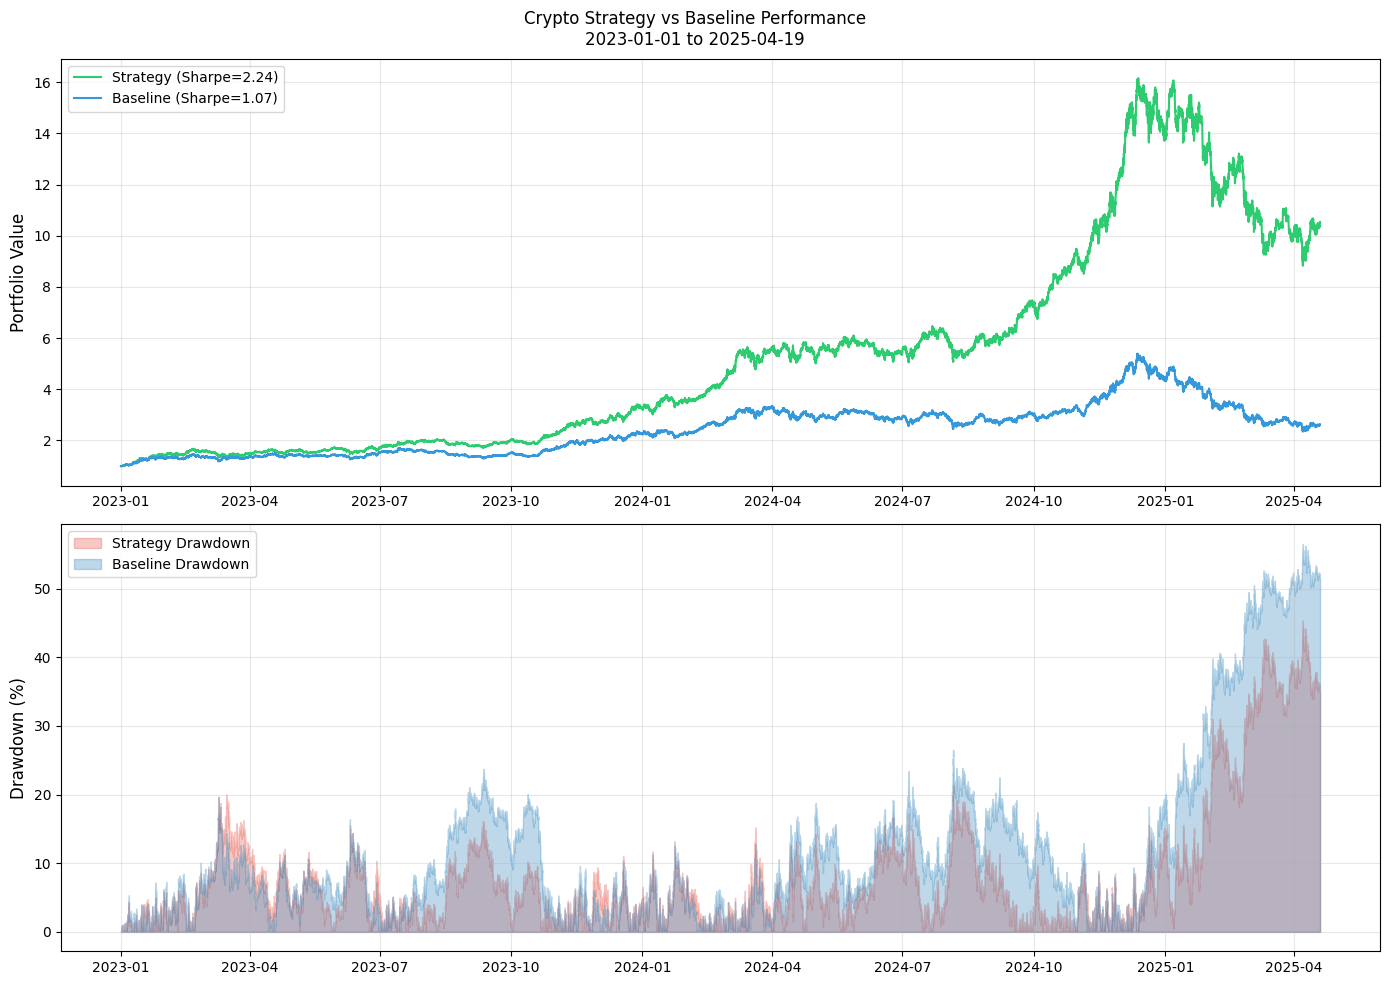

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Constants for hourly data (filtered from 10-minute intervals)
HOURS_PER_YEAR = 24 * 365  # 8,760 hours per year

# 1. Annualized Return
def crypto_annualized_return(net_values):
    total_hours = (net_values.index[-1] - net_values.index[0]).total_seconds() / 3600
    total_return = net_values.iloc[-1] / net_values.iloc[0] - 1
    return (1 + total_return) ** (HOURS_PER_YEAR / total_hours) - 1

# 2. Sharpe Ratio
def crypto_sharpe_ratio(returns, risk_free_rate=0.0):
    hourly_rf = risk_free_rate / HOURS_PER_YEAR
    excess_returns = returns - hourly_rf
    std = excess_returns.std()
    if std == 0:
        return np.nan
    return np.sqrt(HOURS_PER_YEAR) * excess_returns.mean() / std

# 3. Maximum Drawdown
def crypto_max_drawdown(net_values):
    peak = net_values.expanding().max()
    drawdown = (peak - net_values) / peak
    return drawdown.max()

# 4. CAGR
def crypto_cagr(net_values):
    total_hours = (net_values.index[-1] - net_values.index[0]).total_seconds() / 3600
    years = total_hours / HOURS_PER_YEAR
    final_value = net_values.iloc[-1]
    initial_value = net_values.iloc[0]
    return (final_value / initial_value) ** (1 / years) - 1
test["predict"] = y_test_pred
# Compute strategy and baseline returns
# Strategy: Select assets with positive predictions
strategy_returns = test[test['predict'] > 0].groupby('date')['future_return_60m'].mean().reset_index()
strategy_returns = strategy_returns.rename(columns={'future_return_60m': 'strategy_return'})
strategy_returns['date'] = pd.to_datetime(strategy_returns['date'])
strategy_returns = strategy_returns[strategy_returns['date'].dt.minute == 0].copy()

# Baseline: Equal-weighted portfolio
baseline_returns = test.groupby('date')['future_return_60m'].mean().reset_index()
baseline_returns = baseline_returns.rename(columns={'future_return_60m': 'baseline_return'})
baseline_returns['date'] = pd.to_datetime(baseline_returns['date'])
baseline_returns = baseline_returns[baseline_returns['date'].dt.minute == 0].copy()

# Calculate net values
strategy_returns['netvalue'] = (1 + strategy_returns['strategy_return']).cumprod()
strategy_returns['netvalue'] = strategy_returns['netvalue'] / strategy_returns['netvalue'].iloc[0]
baseline_returns['netvalue'] = (1 + baseline_returns['baseline_return']).cumprod()
baseline_returns['netvalue'] = baseline_returns['netvalue'] / baseline_returns['netvalue'].iloc[0]

# Set date as index
strategy_returns = strategy_returns.set_index('date')
baseline_returns = baseline_returns.set_index('date')

# Calculate metrics
strategy_metrics = {
    'Annualized Return': crypto_annualized_return(strategy_returns['netvalue']) * 100,
    'CAGR': crypto_cagr(strategy_returns['netvalue']) * 100,
    'Sharpe Ratio': crypto_sharpe_ratio(strategy_returns['strategy_return'].dropna()),
    'Max Drawdown': crypto_max_drawdown(strategy_returns['netvalue']) * 100,
    'Volatility': strategy_returns['strategy_return'].std() * np.sqrt(HOURS_PER_YEAR) * 100
}

baseline_metrics = {
    'Annualized Return': crypto_annualized_return(baseline_returns['netvalue']) * 100,
    'CAGR': crypto_cagr(baseline_returns['netvalue']) * 100,
    'Sharpe Ratio': crypto_sharpe_ratio(baseline_returns['baseline_return'].dropna()),
    'Max Drawdown': crypto_max_drawdown(baseline_returns['netvalue']) * 100,
    'Volatility': baseline_returns['baseline_return'].std() * np.sqrt(HOURS_PER_YEAR) * 100
}

# Create metrics table
metrics_table = [
    ['CAGR (%)', f"{strategy_metrics['CAGR']:.2f}", f"{baseline_metrics['CAGR']:.2f}"],
    ['Sharpe Ratio', f"{strategy_metrics['Sharpe Ratio']:.2f}", f"{baseline_metrics['Sharpe Ratio']:.2f}"],
    ['Max Drawdown (%)', f"{strategy_metrics['Max Drawdown']:.2f}", f"{baseline_metrics['Max Drawdown']:.2f}"],
    ['Volatility (%)', f"{strategy_metrics['Volatility']:.2f}", f"{baseline_metrics['Volatility']:.2f}"]
]

# Print table
print("\nCrypto Strategy vs Baseline Performance")
print(tabulate(metrics_table, headers=['Metric', 'Strategy', 'Baseline'], tablefmt='grid'))

# Visualize net value curves and drawdowns
plt.figure(figsize=(14, 10))

# Net value plot
ax1 = plt.subplot(211)
ax1.plot(strategy_returns.index, strategy_returns['netvalue'], label=f'Strategy (Sharpe={strategy_metrics["Sharpe Ratio"]:.2f})', color='#2ecc71')
ax1.plot(baseline_returns.index, baseline_returns['netvalue'], label=f'Baseline (Sharpe={baseline_metrics["Sharpe Ratio"]:.2f})', color='#3498db')
ax1.set_ylabel('Portfolio Value', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Drawdown plot
ax2 = plt.subplot(212, sharex=ax1)
strategy_drawdown = (strategy_returns['netvalue'].cummax() - strategy_returns['netvalue']) / strategy_returns['netvalue'].cummax()
baseline_drawdown = (baseline_returns['netvalue'].cummax() - baseline_returns['netvalue']) / baseline_returns['netvalue'].cummax()
ax2.fill_between(strategy_returns.index, strategy_drawdown * 100, 0, color='#e74c3c', alpha=0.3, label='Strategy Drawdown')
ax2.fill_between(baseline_returns.index, baseline_drawdown * 100, 0, color='#2980b9', alpha=0.3, label='Baseline Drawdown')
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Title and layout
plt.suptitle(f'Crypto Strategy vs Baseline Performance\n{strategy_returns.index[0].date()} to {strategy_returns.index[-1].date()}', y=0.98)
plt.tight_layout()
plt.savefig('strategy_vs_baseline_performance.png')
plt.show()